# 분류

## MNIST 데이터 다운 및 분할

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/Users/goodyoung/Desktop/GIt/myMLstudy/.mlvenv/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,Y = mnist['data'],mnist['target']

In [3]:
X.shape

(70000, 784)

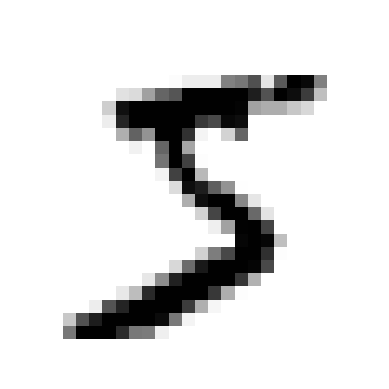

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [5]:
# target 정수형으로 변환
import numpy as np
Y = Y.astype(np.uint8)

In [6]:
# train, test split
X_train, X_test, y_train, y_test = X[:60000],X[60000:],Y[:60000],Y[60000:]

## 이진 분류기 훈련

In [7]:
# 5-감지기
# 5와 5아님
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### 확률적 경사 하강법(SGD) 사용

- SGD 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있다.
- SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문
  - SGD가 온라인 학습에 잘 들어 맞는다.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([X[0]])

array([ True])

# 성능 측정
- 분류기 평가는 회귀 모델보다 훨씬 어렵다.
- 사용할 수 있는 성능 지표가 많다.

## 교차 검증 폴드 성능 측정
- 모든 정확도가 90 이상이다.
  - 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다.
  - 특히 불균형한 데이터셋을 다룰 때 더욱 그렇다.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42,shuffle = True)

# cross_val_score() 거의 같은 작업을 수행하고 동일한 결과를 출력한다.
for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    X_test_fold = X_train[test_idx]
    y_test_fold = y_train_5[test_idx]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


- StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행합니다.

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

##### 모든 이미지를 5 아님 클래스로 분류하는 더미 분류기 성능 측정

In [12]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y = None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype = bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## 오차 행렬
- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다.
  - 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다 -> 오차행렬의 5행 3열을 보자

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
y_train_pred[:50]

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False])

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차행렬의 행은 실제 클래스, 열은 예측한 클래스
- 이 행렬의 첫 번째 행은 '5아님'(음성 클래스)
  - 53000개를 5아님으로 정확하게 분류 (진짜 음성)
  - 687개를 5라고 잘못 분류 (거짓 양성)
- 두 번쨰 행은 5이미지(양성 클래스)
  - 1800개를 5아님으로 잘못 분류 (거짓 음성)
  - 3500개를 정확히 5라고ㅓ 분류 (진짜 양성)

In [17]:
# 완벽한척 하자
# 만약 분류기가 완벽했다면..
y_train_perfect_predictions = y_train_5  
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 정밀도(precision)(양성 예측에 대한 정확도),
- 재현율(recall)(분류기가 정확하게 감지한 양성 샘플의 비율) 이랑 같이 쓰임

## 정밀도 & 재현율 & f1score

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
# 정밀도
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [20]:
# 재현율
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [22]:
#f1 score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [23]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

- F1 score는 정밀도와 재현율의 조화 평균
- 정밀도와 재현율이 비슷한 분류기에서는 f1점수가 높다.
- 어링나이에게 안전한 동영상을 걸러내는 분류기의 경우
  - 재현율은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다
  - 좋은 동영상이 많이 제외되더라도(낮은 재현율) 안전한 것들만 노출시키는(높은 정밀도) 분류기를 선호한다.
- 감시 카메라를 통해 좀도둑을 잡아내는 분류기
  - 분류기의 재현율이 99 라면 정확도가 30퍼만 되더라도 괜찮을지 모른다. (거의 모든 좀도둑을 잡는다.)
- 정밀도/재현율 트레이드 오프
  - 둘 다 모두 얻을 수는 없다.

## 정밀도 / 재현율 트레이드오프

### 임계값 확인

In [24]:
# 모델의 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

#### 임계값을 0으로 설정한다면

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True])

#### 임계값을 8000으로 설정한다면

In [26]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### 적절한 임계값을 정하기

In [27]:
#모든 샘플의 점수
#method를 지정하여 결정 점수를 반환 받게 한다.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [28]:
# 이 점수로 모든 임계값에 대해 정밀도와 재현율을 계산할 수 있게 된다.
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

정밀도와 재현율 그리기

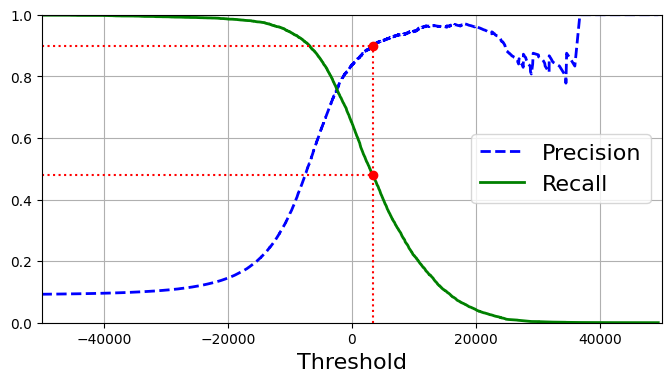

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
# save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

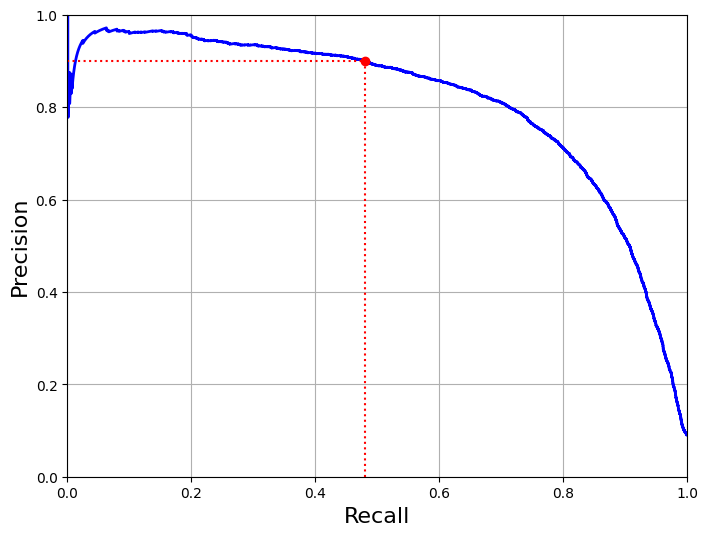

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

- 재현율 80퍼 근처에서 정밀도가 급격하게 줄어든다.
- 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.

In [31]:
np.argmax(np.array([1,2,3,4,623123124,234,24,41,56,46,234,623123124,12342]) >= 100)

4

In [34]:
thresholds

array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
         38871.26391927,   42216.05562787,   49441.43765905])

In [72]:
# argmax: precision이 0.9보다 큰 값의 첫번째 인덱스
thresholds[np.argmax((precisions >= 0.90) & (0.3 <= recalls) & (recalls <= 0.48))]
#이게 맞는 것 같다.

3370.0194991439557

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [37]:
threshold_90_precision

3370.0194991439557

In [45]:
max(thresholds)

49441.437659047755

In [46]:
for i in range(len(thresholds)):
    if thresholds[i] == 49441.437659047755:
        print(i)

59999


In [47]:
precisions[59999]

1.0

In [78]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [67]:
# 정밀도 90을 달성한 분류기
y_train_pred_90 = (y_scores >= 3370.0194991439557)

In [68]:
precision_score(y_train_5, y_train_pred_90)
# 기존: 0.9000345901072293

0.9000345901072293

In [69]:
recall_score(y_train_5, y_train_pred_90)
# 기존: 0.4799852425751706

0.4799852425751706

## ROC 곡선
- 수신기 조작 특성 곡선
- 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR: 재현율의 다른 이름)의 곡선이다.
- 이는 1에서 진짜 음성 비율(TNR: 특이도)을 뺸 값
- ROC곡선: 민감도에 대한 `1-특이도` 그래프

In [96]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

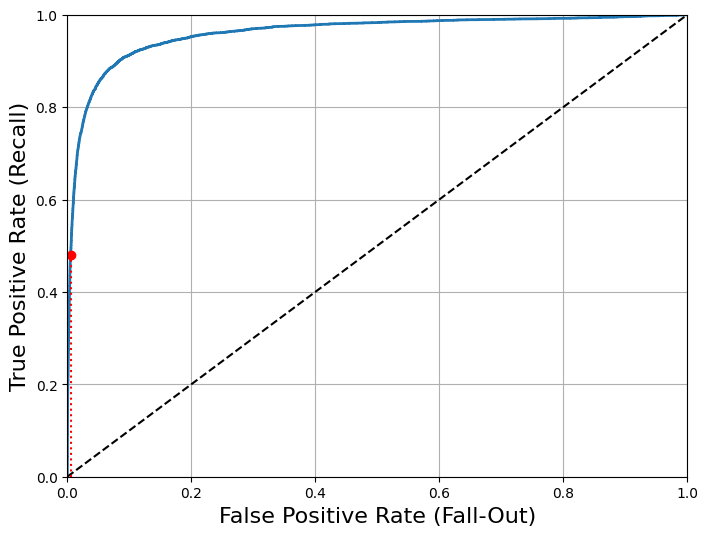

In [97]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

- 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다.
- 점선: 완전한 랜덤 분류기의 ROC곡선을 뜻한다
  - 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야한다.
- 곡선 아래의 면적(`AUC`): 분류기들을 비교할 수 있다.
  - 완벽한 분류기는 ROC의 AUC가 1
  - 완전한 랜덤 분류기는 0.5이다.

 ### PR곡선 vs ROC곡선?
- 양성 클래스가 드물거나 거짓음성보다 거짓 양성이 더 중요할 때 PR곡선을 사용하고
- 그렇지 않으면 ROC곡선을 사용한다.

In [99]:
# AUC 면적
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)


0.9604938554008616

## 여러 모델 ROC 비교
- randomForestClassifier는 `decision_function()` 메서드가 없고`predict_proba()` 메서드가 있다.
- `predict_proba()`: 주어진 클래스에 속할 확률을 담은 배열을 반환 (어떤 이미지가 5일 확률 70%)

In [100]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [48]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

그림 저장: roc_curve_comparison_plot


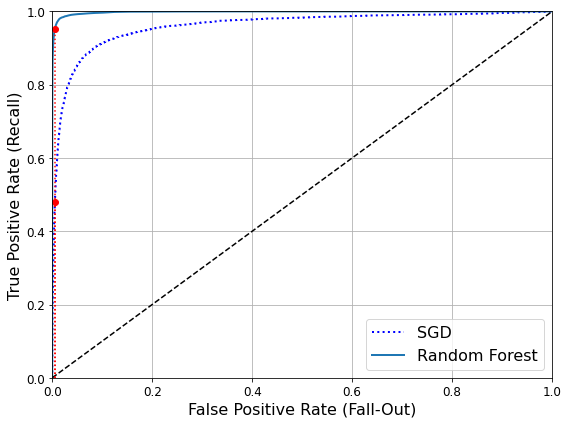

In [49]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

# 다중 분류

## 다양한 기법
- `OvR (one-versus-the-rest)`: 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만드는 방법
  - 이미지 분류시 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
- `OvO (one-versus-one)`: 0과1 구별, 0과2 구별 등 각 숫자의 조합 마다 이진 분류기를 훈련시키는 것이다. 클래스가 N개면 `N*(N-1)/2` 가 필요하다.
  - 장점은 각 분류기의 훈련에 전체 훈련 세트 중에 구별할 두 클래스에 해당하는 샘플만 필요하다는 것이다.

In [103]:
#사이킷런이 ovo 전략을 사용해 45개의 이진 분류기를 훈련시키고 각각의
#결정 점수를 얻어 점수가 가장 높은 클래스를 선택합니다.
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([X[0]])

array([5], dtype=uint8)

In [105]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores, np.argmax(some_digit_scores))

[[ 2.81585438  7.09167958  3.82972099  0.79365551  5.8885703   9.29718395
   1.79862509  8.10392157 -0.228207    4.83753243]] 5


OVO나 OVR사용을 강제하는 방법

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

SGD 분류기이나, randomforest는 다중 클래스를 분류할 수 있기때문에 별도로 지정안해도 된다.

In [107]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [108]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

# 에러 분석
- 모델의 성능 향상을 위한 방법

### 오차행렬 분석

In [110]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

In [118]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

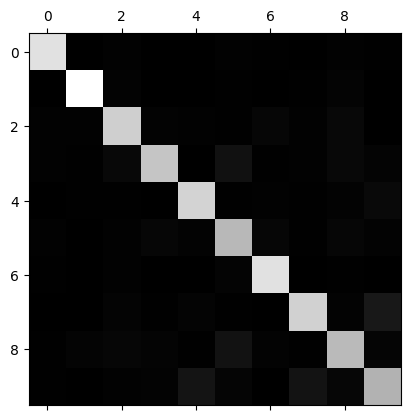

In [119]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 에러 부분에 초점
- 오차행렬의 각 값에 대응되는 클래스의 이미지 개수로 나누기
- 각 대각선은 0으로 채우기

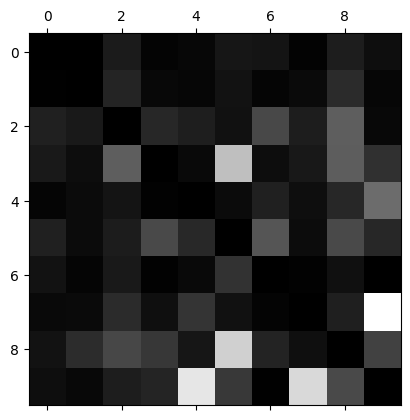

In [120]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 많은 이미지가 8로 잘못 분류되었다.
- 오차행렬은 반드시 대칭은 아니다.
- 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다.
  - 8로 잘못 분류를 줄이도록 개선할 수 있다.
    - 훈련데이터 더 많이 모으기
    - 분류기에 도움이 될 만한 특성들을 더 찾아보기

# 다중 레이블 분류
- 분류기가 샘플마다 여러개의 클래스를 출력해야 할 때

다중 레이블: 숫자가 큰 값인지 or 홀수인지

In [121]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [123]:
knn_clf.predict([X[0]])
# 5는 크지 않고, 홀수이다.

array([[False,  True]])

### 분류기 평가

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 다중 출력 분류
- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록하는 것.
- 값을 두 개 이상 가질 수 있게된다.

In [124]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test